# Topic Classification Using Unsupervised and Supervised Approaches Part 1
This assignment compares how well unsupervised matrix factorisation and two supervised learning models classify [BBC News data](https://www.kaggle.com/competitions/learn-ai-bbc/data). The assignment has been split into two notebooks - this one focuses on the unsupervised algorithm.

In [1]:
# general libraries
from itertools import product
import numpy as np
import pandas as pd
from time import time

# visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# modelling libraries
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import spacy

# get rid of the seaborn FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Task 1: Exploratory Data Analysis

In [2]:
# load the data
train = pd.read_csv('./data/learn-ai-bbc/BBC News Train.csv')
test = pd.read_csv('./data/learn-ai-bbc/BBC News Test.csv')

# take a look at the first few rows of each dataset
train.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [3]:
test.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


Notice that the test dataset doesn't include labels, so it couldn't be used directly for model performance evaluation. Instead this was done fully on the training dataset. Also, note that all the text is already in lower-case, which means it didn't have to be included in the data cleaning.

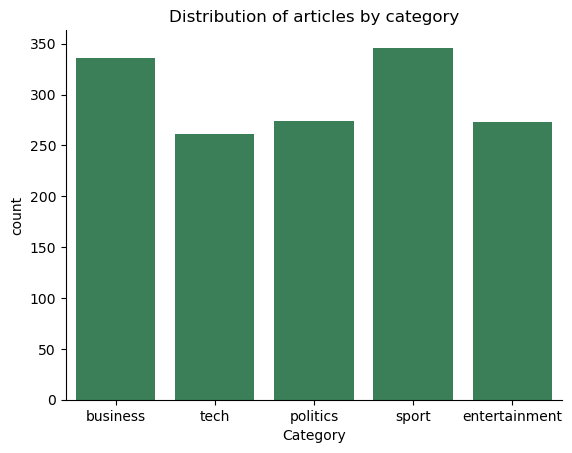

In [4]:
# check out the distribution of category labels
sns.countplot(data=train, x="Category", color="seagreen")
plt.title("Distribution of articles by category")
sns.despine()

The distribution is fairly even, which was good for the supervised component of this analysis as classification algorithms typically have a tendency to focus on the majority class without some adjustment (resampling, changing weights etc). However, business and sports articles are slightly more common than tech, politics or entertainment articles.

In [5]:
# check out the number of tokens in the articles
train['NumChars'] = train.Text.apply(lambda x: len(x))
train['NumWords'] = train.Text.apply(lambda x: len(x.split()))

train.groupby('Category')['NumWords'].median()

Category
business         304.0
entertainment    272.0
politics         441.5
sport            294.5
tech             457.0
Name: NumWords, dtype: float64

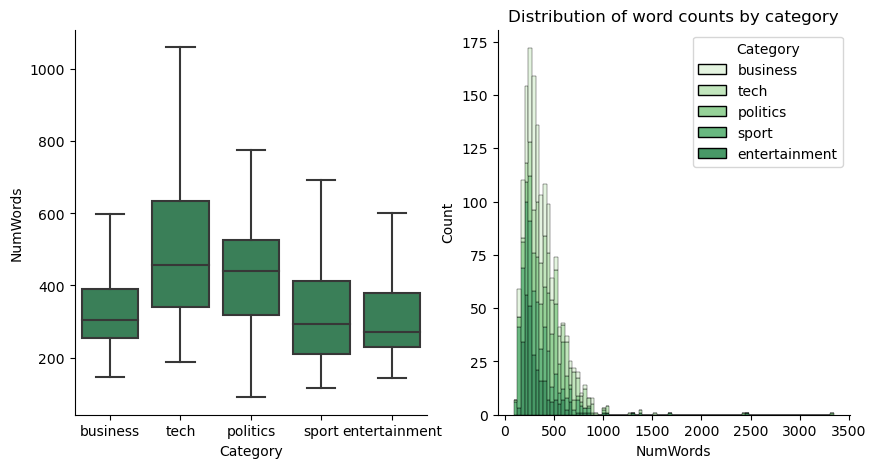

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(data=train, x="Category", y="NumWords", showfliers=False, color="seagreen", ax=axs[0])
plt.title("Distribution of word counts by category")
sns.despine()

sns.histplot(data=train, x="NumWords", hue="Category", color="seagreen", multiple="stack", palette="Greens", ax=axs[1])
plt.title("Distribution of word counts by category")
sns.despine()

Tech and politics articles tended to have the largest number of words per article, but the distributions by category are faily similar; that is, there are more shorter articles and a relatively long right tail to all the distributions with a couple of significant outliers.

In [13]:
# load the english spacy model
nlp = spacy.load("en_core_web_lg")

t0 = time()
# apply the spacy model to the training data
processed_docs = [nlp(text) for text in train.Text]
print("Done in %0.3fs." % (time() - t0))

done in 105.456s.


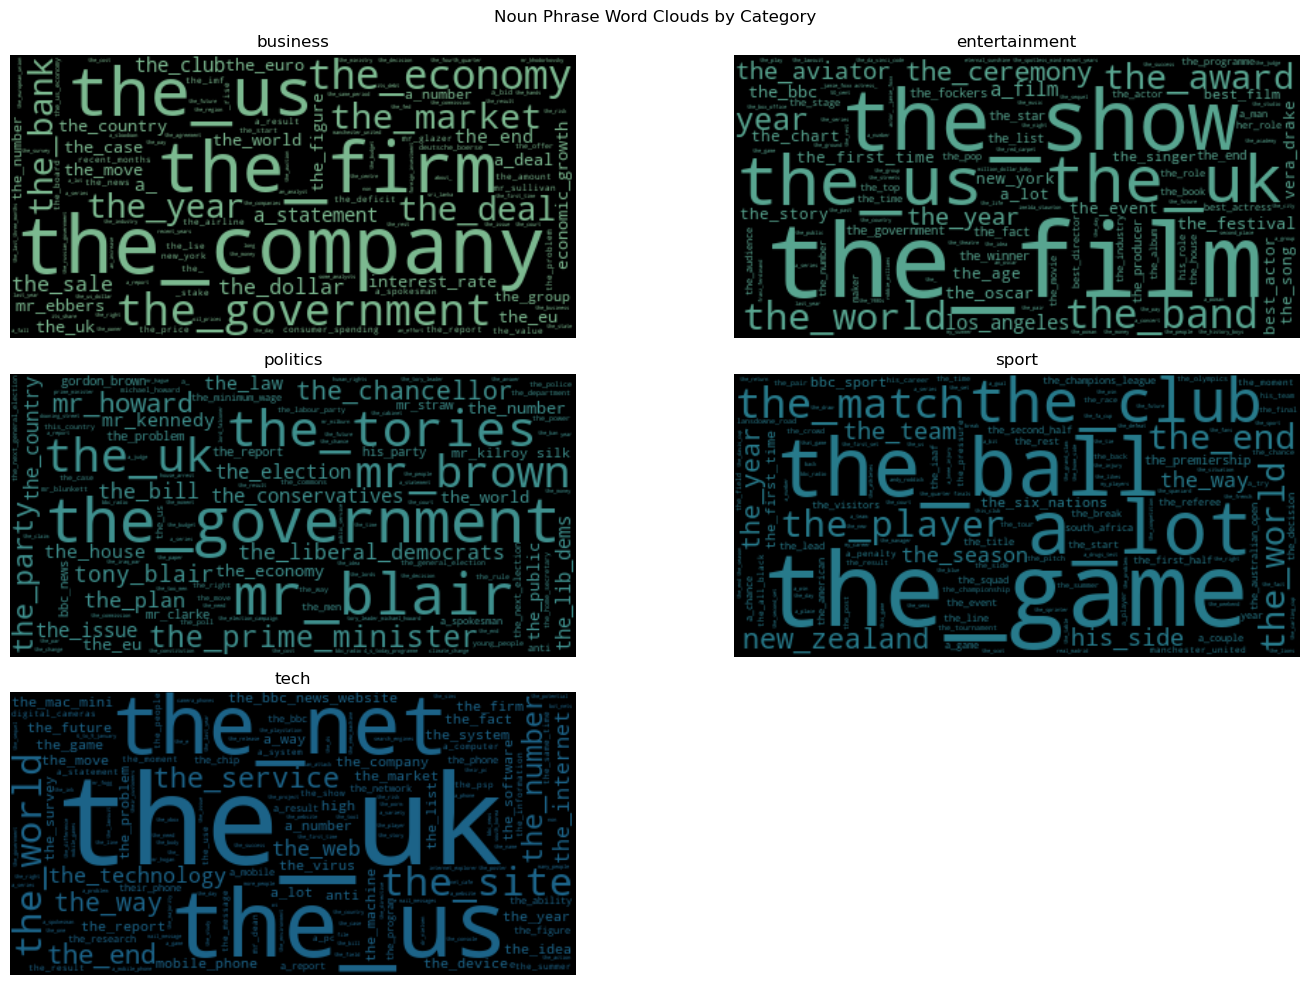

In [14]:
# extract noun chunks
doc_noun_phrases = []
doc_noun_phrases_joined = []
for doc in processed_docs:
    phrases = [chunk.text for chunk in doc.noun_chunks]
    phrases2 = [phrase.replace(" ", "_") for phrase in phrases]
    doc_noun_phrases.append(phrases)
    doc_noun_phrases_joined.append(phrases2)
# noun_phrases = [phrases for doc in doc_noun_phrases for phrases in doc]
# noun_phrases_joined = [phrases for doc in doc_noun_phrases_joined for phrases in doc]
train['NounPhrases'] = doc_noun_phrases
train['NounPhrasesJoined'] = doc_noun_phrases_joined

# create a version without single words
doc_noun_phrases = []
doc_noun_phrases_joined = []
for doc in train.NounPhrases:
    # lengths = [len(token.split()) for token in doc]
    phrases = [token for token in doc if len(token.split()) > 1]
    phrases2 = [phrase.replace(" ", "_") for phrase in phrases]
    doc_noun_phrases.append(phrases)
    doc_noun_phrases_joined.append(phrases2)
train['NounPhrasesSub'] = doc_noun_phrases
train['NounPhrasesJoinedSub'] = doc_noun_phrases_joined

# convert list to strings
train['NounStrings'] = train.NounPhrasesJoined.apply(lambda x: " ".join(x))
train['NounStringsSub'] = train.NounPhrasesJoinedSub.apply(lambda x: " ".join(x))

# create a colour map dictionary and convert the RGB tuples to hexidecimal
color_dict = {'business': sns.color_palette("crest")[0],
              'entertainment': sns.color_palette("crest")[1],
              'politics': sns.color_palette("crest")[2],
              'sport': sns.color_palette("crest")[3],
              'tech': sns.color_palette("crest")[4]}


def rgb_to_hex(rgb):
    return "#{:02x}{:02x}{:02x}".format(int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255))

color_dict = {category: rgb_to_hex(rgb) for category, rgb in color_dict.items()}

# group and join the phrases from each category
grouped_train_sub = train.groupby('Category')['NounStringsSub'].apply(lambda x: ' '.join(x)).reset_index()
grouped_train = train.groupby('Category')['NounStrings'].apply(lambda x: ' '.join(x)).reset_index()

# plot a grid of word clouds
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
for idx, (ax, (category, row)) in enumerate(zip(axs.flatten(), grouped_train_sub.iterrows())):
    category = row['Category']
    phrases = row['NounStringsSub']

    wc = WordCloud(color_func=lambda *args, **kwargs: color_dict[category])
    wc.generate(phrases)
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(f'{category}', fontsize=12)
fig.suptitle('Noun Phrase Word Clouds by Category')
# remove the last empty plot
fig.delaxes(axs.flatten()[-1])
plt.tight_layout()

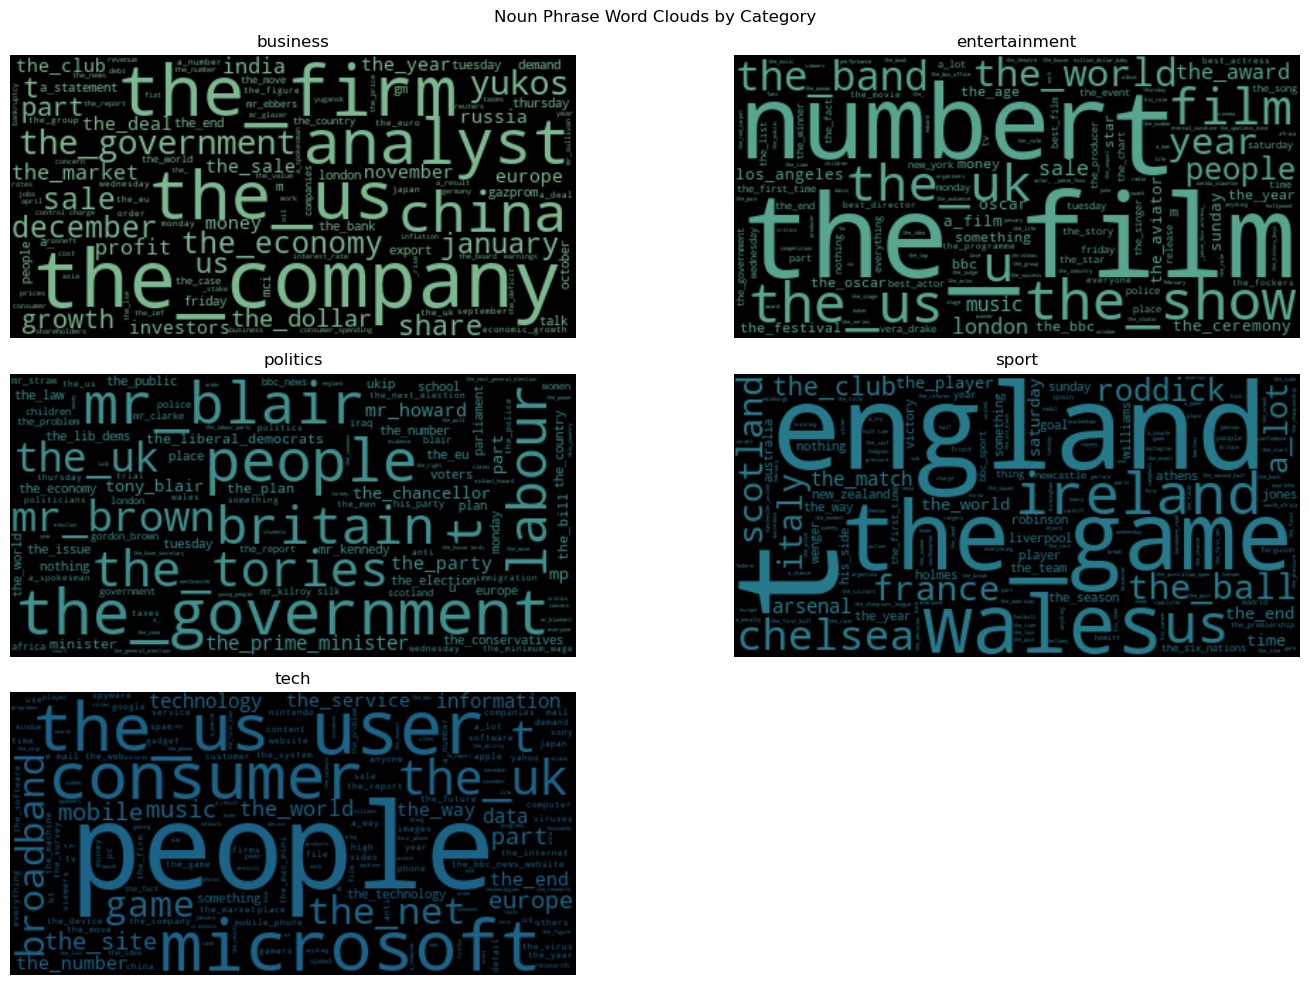

In [15]:
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
for idx, (ax, (category, row)) in enumerate(zip(axs.flatten(), grouped_train.iterrows())):
    category = row['Category']
    phrases = row['NounStrings']

    wc = WordCloud(color_func=lambda *args, **kwargs: color_dict[category])
    wc.generate(phrases)
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(f'{category}', fontsize=12)
fig.suptitle('Noun Phrase Word Clouds by Category')
# remove the last empty plot
fig.delaxes(axs.flatten()[-1])
plt.tight_layout()

The first word cloud excluded unigrams, and the second set left them in. Either way, they are both consistent and even without the headings, it would be reasonably clear what the different categories were about: 'business' mentions things like markets, companies, the economy; 'entertainment' mentions films, shows and awards; 'politics' is very UK-specific with things the tories and Tony Blair; 'sport' mentions games, matches and players; and 'tech' mentions things like technology, service, internet and names of countries.

## Task 2: Data Pre-Processing

The pre-processing for text data is typically slightly different to how it would be approached for a regular tabulardataset. Specifically, it needs to be essentially converted into a numeric representation that a machine can understand. Techniques employed to do this include things like converting all text into a single case (usually lower-case), splitting text into individual words (tokenising), removing extraneous information like punctuation, numbers and symbols, and 'noise' words that provide next-to-no extra information (stopwords). However, more modern approaches using Large Language Models for example, often use this information to provide extra context, so whilst they may still tokenise the text, the removal of certain tokens may not occur. In addition, there is other processing like padding out each tokenised string to the same length and adding a mask to differentiate between the content and the padding.

This analysis used a more classical text pre-processing pipeline.

In [16]:
def process_text(data_series, alphanumeric_tokens = True, single_tokens = False):
    # apply the spacy model to the input text data
    processed_docs = [nlp(text) for text in data_series]

    clean_docs = []
    clean_text = []
    for doc in processed_docs:
        if alphanumeric_tokens == True:
            if single_tokens == False:
                clean_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and
                                token.is_alpha and len(token) > 1]
            else:
                clean_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and
                                token.is_alpha]
        else:
            if single_tokens == False:
                clean_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and
                                len(token) > 1]
            else:
                clean_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
        clean_docs.append(clean_tokens)

        clean_strings = ' '.join(clean_tokens)
        clean_text.append(clean_strings)

    return clean_docs, clean_text

# convert list to strings
t0 = time()
clean_docs, clean_text = process_text(train.Text)
train['CleanTokens'] = clean_docs
train['CleanText'] = clean_text
print("Done in %0.3fs." % (time() - t0))

done in 112.138s.


In [17]:
# an example of the original text
doc_idx = 1489
train.Text[doc_idx]

'santy worm makes unwelcome visit thousands of website bulletin boards have been defaced by a virus that used google to spread across the net.  the santy worm first appeared on 20 december and within 24 hours had successfully hit more than 40 000 websites. the malicious program exploits a vulnerability in the widely used phpbb software. santy s spread has now been stopped after google began blocking infected sites searching for new victims.  the worm replaces chat forums with a webpage announcing that the site had been defaced by the malicious program. soon after being infected  sites hit by the worm started randomly searching for other websites running the vulnerable phpbb software. once google started blocking these search queries the rate of infection tailed off sharply. a message sent to finnish security firm f-secure by google s security team said:  while a seven hour response for something like this is not outrageous  we think we can and should do better.   we will be reviewing o

In [18]:
# the same example but pre-processed
train.CleanText[doc_idx]

'santy worm make unwelcome visit thousand website bulletin board deface virus google spread net santy worm appear december hour successfully hit website malicious program exploit vulnerability widely phpbb software santy spread stop google begin block infected site search new victim worm replace chat forum webpage announce site deface malicious program soon infect site hit worm start randomly search website run vulnerable phpbb software google start block search query rate infection tail sharply message send finnish security firm secure google security team say seven hour response like outrageous think well review procedure improve response time future similar problem google team say security firm estimate website run discussion group forum open source phpbb program bad attack search conduct morning december produce hit site show text defacement message people site hit santy affect worm santy malicious program use google help spread july variant mydoom virus slow search google program 

In [19]:
train.CleanTokens[doc_idx]

['santy',
 'worm',
 'make',
 'unwelcome',
 'visit',
 'thousand',
 'website',
 'bulletin',
 'board',
 'deface',
 'virus',
 'google',
 'spread',
 'net',
 'santy',
 'worm',
 'appear',
 'december',
 'hour',
 'successfully',
 'hit',
 'website',
 'malicious',
 'program',
 'exploit',
 'vulnerability',
 'widely',
 'phpbb',
 'software',
 'santy',
 'spread',
 'stop',
 'google',
 'begin',
 'block',
 'infected',
 'site',
 'search',
 'new',
 'victim',
 'worm',
 'replace',
 'chat',
 'forum',
 'webpage',
 'announce',
 'site',
 'deface',
 'malicious',
 'program',
 'soon',
 'infect',
 'site',
 'hit',
 'worm',
 'start',
 'randomly',
 'search',
 'website',
 'run',
 'vulnerable',
 'phpbb',
 'software',
 'google',
 'start',
 'block',
 'search',
 'query',
 'rate',
 'infection',
 'tail',
 'sharply',
 'message',
 'send',
 'finnish',
 'security',
 'firm',
 'secure',
 'google',
 'security',
 'team',
 'say',
 'seven',
 'hour',
 'response',
 'like',
 'outrageous',
 'think',
 'well',
 'review',
 'procedure',
 'imp

## Task 3: Feature Extraction

As mentioned previously, computers don't understand text and need it to be converted into a numeric representation before it can be input into a machine learning algorithm. One of the simplest approach is 'Bag of Words', which represents each document as the count of each token in the entire dataset, where a token could be a single word and/or a longer n-gram. One slight variation on this idea is to weight tokens by how frequently they appear in a particular documents by how many documents in the datasets they are in. The idea behind the approach is two-fold: firstly, more important terms should receive a words that are less important. Secondly, a term should be considered more important if it appears frequently in a subset of the documents, and less important if it either appears infrequently or appears frequently across every document. The formal name for the approach is Term Frequency-Inverse Document Frequency or TF-IDF vectorisation, and is the text feature generation approach that will be used for the analysis.

In addition, the EDA indicated that there were some very long articles in the dataset. These were removed in case the algorithm mistakenly used the length of the articles to infer something about how they should be categorised.

In [20]:
# remove articles in the top 1%
top = np.quantile(train.NumWords, q=0.99)
train_sub = train.loc[train.NumWords < top]

The effect of removing the top 1% of articles was almost nill on the mean and median word count, but brought the maximum down significantly (from 3,345 words to 464).

In [21]:
# create a tfidf vectoriser with default arguments (extracts single word tokens, doesn't remove stopwords, expects
# strings, use all features etc)
train_vec = TfidfVectorizer()
train_mat = train_vec.fit_transform(train_sub.CleanText)

## Task 4: Unsupervised Learning - Matrix Factorisation

When you train the unsupervised model for matrix factorisation, should you include texts (word features) from the test dataset or not as the input matrix? Why or why not?

Text / word features from the test set should be included in the input matrix as there may be features in the test set only. If the model comes across new features it hasn't seen before during model training then it won't know how to handle them. This isn't technically classified as data leakage as the ground truth labels aren't being used to help the model learn.

In [22]:
# combine the train and test datasets together to build a Tf-Idf matrix with the entire vocabulary
train_test = pd.concat([train[['ArticleId', 'Category', 'Text']], test[['ArticleId', 'Text']]])
# count the number of words in each article and remove the top 1%
train_test['NumWords'] = train_test.Text.apply(lambda x: len(x.split()))
train_test.NumWords.describe()
train_test_sub = train_test.loc[train_test.NumWords < top]
# again has very little impact on the mean/median, but removes all the very long outlying articles
train_test_sub.NumWords.describe()

count    2200.000000
mean      374.916818
std       167.142776
min        90.000000
25%       249.000000
50%       334.000000
75%       470.000000
max       994.000000
Name: NumWords, dtype: float64

In [23]:
# process the raw strings
t0 = time()
_, clean_text = process_text(train_test_sub.Text)
train_test_sub.loc[:, 'CleanText'] = clean_text
print("Done in %0.3fs." % (time() - t0))

done in 156.494s.


C:\Users\nikki.fitzherbert\AppData\Local\Temp\ipykernel_5396\1852975883.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_test_sub.loc[:, 'CleanText'] = clean_text


In [31]:
# use the default parameters for now (we'll play with them later)
tfidf_vec = TfidfVectorizer()
# apply the vectoriser to the combined dataset
train_test_mat = tfidf_vec.fit_transform(train_test_sub.CleanText)
# get the vocab (this is important for identifying the top terms in a topic)
vocab = np.array(tfidf_vec.get_feature_names_out())
# vocab = tfidf_vec.vocabulary_  # this is a dictionary representation

print(train_test_mat.shape)

(2200, 21362)


There are 21,389 tokens across 2,202 articles. To reduce the number of terms in the vocabulary, terms that only appear in 1 article and/or 95% of articles could be filtered out for example. Note that the number of features in the matrix is the same as the number of terms in the vocabulary.

sklearn's implementation of non-negative matrix factorisation (NMF) was used to extract the topic structure. NMF decomposes a document feature matrix into two component matrices that are iteratively adjusted until the difference between the original matrix and the product of these component matrices is minimised. What this means for text classification is that each document is represented as a linear combination of topics, and then each document is given the label of the most representative topic. Other matrix factorisation methods include latent semantic analysis (TruncatedSVD in sklearn) or Latent Dirichlet Allocation. Whilst LDA is a popular algorithm, NMF can sometimes produce more coherent topics. The choice of algorithm for this analysis was largely random and the author wanted to try something other than the popular LDA and LSA approaches.

Recall that the idea of NMF is to extract an additive model of the topic structure of the corpus. The output is a list of topics, with each topic represented by a list of terms (words in this case). The dimensionality of the problem and hence the runtime can be controlled by the number of documents, number of topics (n_components) and the number of features in the vectoriser (max_features).

In [26]:
# we know that there are 5 topics, so we can explicitly specify this
nmf_init = NMF(n_components=5, init='nndsvd', random_state=42)
# extract the component matrices
nmf_W1_document_topics = nmf_init.fit_transform(train_test_mat)
nmf_H1_topic_terms = nmf_init.components_

# take a look at the top terms from each topic and map them to the known categories
num_terms = 10
topic_terms = pd.DataFrame(np.apply_along_axis(lambda x: vocab[(np.argsort(-x))[:num_terms]], 1, nmf_H1_topic_terms))
topic_terms.reset_index(inplace=True)
topic_terms.rename(columns={'index': 'Category'}, inplace=True)
topic_dict = {0: 'sport', 1: 'politics', 2: 'tech', 3: 'entertainment', 4: 'business'}
topic_terms['Category'] = topic_terms.Category.map(topic_dict)
topic_terms

,Category,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,sport,game,win,england,play,player,say,match,team,cup,...,final,injury,good,year,coach,world,time,club,rugby,france
1,politics,mr,labour,election,blair,party,say,tory,brown,minister,...,government,tax,chancellor,prime,plan,conservative,leader,campaign,lib,people
2,tech,mobile,phone,people,technology,music,say,service,digital,user,...,net,network,software,use,microsoft,computer,firm,video,device,tv
3,entertainment,film,award,good,oscar,star,actor,festival,win,actress,...,director,year,prize,comedy,aviator,include,movie,category,nominate,ceremony
4,business,growth,economy,rate,rise,say,bank,price,year,economic,...,fall,sale,oil,dollar,china,month,figure,company,quarter,euro


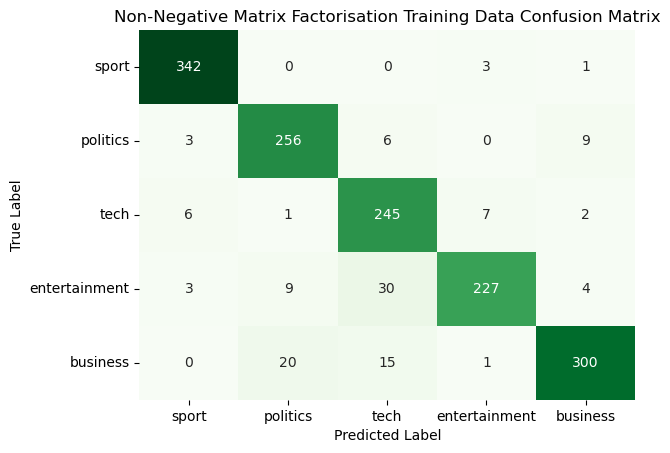

In [27]:
# Use the model to predict the labels of the train and test set
def generate_predictions(vectoriser, df, text_col, model, label_col, topic_dict):
    vectors = np.array(vectoriser.transform(df[text_col]).todense())
    preds = model.transform(vectors)
    pred_df = pd.DataFrame(np.argmax(preds, axis=1).reshape(-1, 1), columns=['Predicted'])
    pred_df['PredictedLabel'] = pred_df.Predicted.map(topic_dict)
    pred_df['ArticleId'] = df['ArticleId']

    if label_col is None:
        pass
    else:
        topic_dict_rev = {'sport': 0, 'politics': 1, 'tech': 2, 'entertainment': 3, 'business': 4}
        pred_df['Actual'] = df[label_col].map(topic_dict_rev)
        pred_df['ActualLabel'] = pred_df.Actual.map(topic_dict)

    return pred_df

train_preds = generate_predictions(tfidf_vec, train, 'CleanText', nmf_init, 'Category', topic_dict)

# Calculate and display a confusion matrix and some accuracy metrics like F1 and accuracy
def plot_confusion_matrix(true_labels, predicted_labels, topic_dictionary):
    cm = confusion_matrix(y_true=true_labels, y_pred=predicted_labels)
    cm_df = pd.DataFrame(cm, columns=topic_dictionary, index=topic_dictionary)
    # cm_df = pd.DataFrame(cm, columns=topic_dictionary, index=topic_dictionary)
    ax = sns.heatmap(cm_df, annot=True, fmt=".0f", cbar=False, cmap="Greens")
    ax.set(xlabel="Predicted Label", ylabel="True Label",
           title='Non-Negative Matrix Factorisation Training Data Confusion Matrix')

plot_confusion_matrix(train_preds.Actual, train_preds.Predicted, list(topic_dict.values()))

In [28]:
accuracy = accuracy_score(train_preds.Actual, train_preds.Predicted)
print("Training data accuracy: %.4f" % accuracy)

Training data accuracy: 0.9195


In [29]:
f1 = f1_score(train_preds.Actual, train_preds.Predicted, average='weighted')
print("Training data F1 score: %.4f" % f1)

Training data F1 score: 0.9194


In [30]:
# preprocess the test data
t0 = time()
_, clean_text = process_text(test.Text)
test.loc[:, 'CleanText'] = clean_text
print("Done in %0.3fs." % (time() - t0))

done in 53.012s.


In [32]:
test_preds = generate_predictions(tfidf_vec, test, 'CleanText', nmf_init, None, topic_dict)
kaggle_submission = test_preds.loc[:, ['ArticleId', 'PredictedLabel']]
kaggle_submission.columns=['ArticleId', 'Category']
# kaggle_submission.to_csv('./outputs/kaggle submission nmf init.csv', index=False)

It looks like the algorithm does pretty well. Accuracy is around 92% on the training data. The problem areas are mistaking business articles for politics and tech articles, and a little bit surprisingly, entertainment articles for tech articles. When submitted to the kaggle platform, accuracy increased slightly to around 93%, confirming that the model was already doing reasonably well out-of-the-box.

## Task 5: Hyperparameter Tuning

Coul it do even better? A grid search approach was used to test whether changing some of the hyperparameters improves performance. The hyperparameters included the initialisation method, the solver, the beta divergence method, W and H regularisation, and regularisation mixing. Additional parameters that weren't tuned included using higher-order n-grams instead of just words and including the very long articles as well.

Note that this script was initially developed and run in a python IDE, so this cell hasn't been run from the notebook because it takes a very long time... up to 2,880 possible combinations! (1.58 hours)

In [ ]:
# split the data into a training and development or validation set. It's best-practice when conducting
# hyperparameter tuning to assess performance on unseen data without touching the actual test set.
X = train.loc[:, ['ArticleId', 'Text', 'CleanTokens', 'CleanText']]
y = train.Category
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
# not entirely sure why I need to reset the indices to get the results to line up.
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

train_data = pd.concat([X_train, y_train], axis=1)
val_data = pd.concat([X_val, y_val], axis=1)

param_grid = {'init': ('nndsvd', 'nndsvda', 'nndsvdar', 'random'),
              'solver': ('mu', 'cd'),
              'beta_loss': ('kullback-leibler', 'frobenius'),
              'alpha_W': [0, 0.0001, 0.001, 0.01, 0.1, 1],
              'alpha_H': ['same', 0, 0.0001, 0.001, 0.01, 0.1, 1],
              'l1_ratio': [0, 0.25, 0.5, 0.75, 1]}

t0 = time()

param_list = []
acc_list = []
f1_list = []

for init, solver, loss, aW, aH, l1 in product(param_grid['init'], param_grid['solver'], param_grid['beta_loss'],
                                              param_grid['alpha_W'], param_grid['alpha_H'], param_grid['l1_ratio']):
    # combinations that I know don't work
    if (solver == 'mu' and init == 'nndsvd') or (solver == 'cd' and loss == 'kullback-leibler') or \
        (solver == 'cd' and init in ['nndsvd', 'nndsvda'] and loss == 'frobenius' and aW > 0 and l1 > 0) or \
        (solver == 'cd' and init in ['nndsvd', 'nndsvda', 'nndsvdar'] and loss == 'frobenius' and aW == 0 and
            (aH in [0.01, 0.1, 1]) and l1 > 0) or \
        (solver == 'mu' and init == 'nndsvda' and loss == 'frobenius' and aW > 0 and aH != 0 and l1 > 0) or \
        (init == 'nndsvdar' and loss == 'frobenius' and aW > 0 and aH != 0 and l1 > 0) or \
        (init == 'random'):
        pass
    else:
        params = [init, solver, loss, aW, aH, l1]
        nmf_tuned = NMF(n_components=5, init=init, solver=solver, beta_loss=loss, max_iter=1000, random_state=42,
                        alpha_W=aW, alpha_H=aH, l1_ratio=l1)
        nmf_tuned.fit(train_test_mat)
        try:
            # predict the training data labels
            train_preds = generate_predictions(tfidf_vec, train, 'CleanText', nmf_tuned, 'Category', topic_dict)
            # calculate the accuracy
            train_acc = accuracy_score(train_preds['ActualLabel'], train_preds['PredictedLabel'])
            train_f1 = f1_score(train_preds['ActualLabel'], train_preds['PredictedLabel'], average='weighted')

            # print and save the results of the better combinations
            if train_acc > 0.5:
                print(params, round(train_acc, 4))

                param_list.append(params)
                acc_list.append(train_acc)
                f1_list.append(train_f1)
        # ValueError: Array passed to NMF (input H) is full of zeros.
        except ValueError:
            print(params, "Error raised")

print("Done in %0.3fh." % ((time() - t0)/60/60))

In [35]:
# results = pd.DataFrame(data={'hyperparameters': param_list, 'accuracy_score': acc_list,
#                              'f1_score': f1_list})
# results.sort_values(by='accuracy_score', inplace=True, ascending=False)
# results.to_csv("./outputs/nmf tuning results.csv", index=False)

results = pd.read_csv('./outputs/nmf tuning results.csv')
results.head()

,hyperparameters,accuracy_score,f1_score
0,"['nndsvda', 'mu', 'kullback-leibler', 1, 0.1, 0]",0.936242,0.936220
1,"['nndsvda', 'mu', 'kullback-leibler', 0.1, 1, 0]",0.934228,0.934036
2,"['nndsvdar', 'mu', 'kullback-leibler', 1, 0.1, 0]",0.929530,0.929201
3,"['nndsvdar', 'mu', 'kullback-leibler', 0, 1, 0]",0.928859,0.928045
4,"['nndsvdar', 'mu', 'kullback-leibler', 0, 1, 0.5]",0.928859,0.928270


In [36]:
# select the best combination and retrain the model to predict the labels on the train and test set
# it's nice to see there's no conflict between the best model based on accuracy vs F1
best_params = results.head(1)
best_params_f1 = results.sort_values(by='f1_score', ascending=False).head(1)
best_params

,hyperparameters,accuracy_score,f1_score
0,"['nndsvda', 'mu', 'kullback-leibler', 1, 0.1, 0]",0.936242,0.93622


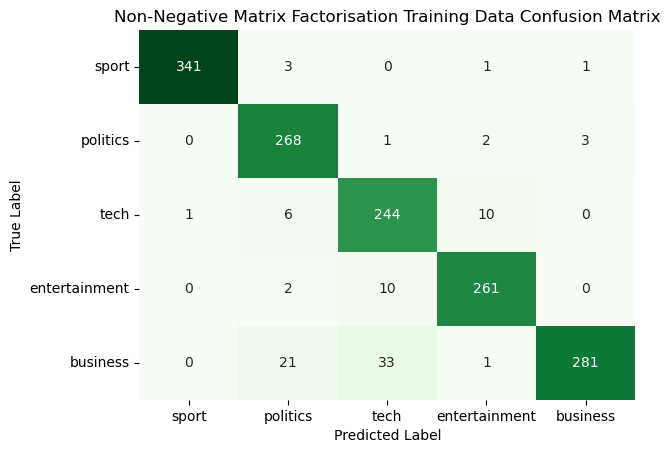

In [38]:
nmf_final = NMF(n_components=5, init='nndsvda', solver='mu', beta_loss='kullback-leibler', max_iter=500,
                random_state=42, alpha_W=1, alpha_H=0.1, l1_ratio=0)
nmf_final.fit(train_test_mat)

train_preds = generate_predictions(tfidf_vec, train, 'CleanText', nmf_final, 'Category', topic_dict)
test_preds = generate_predictions(tfidf_vec, test, 'CleanText', nmf_final, None, topic_dict)

kaggle_submission = test_preds.loc[:, ['ArticleId', 'PredictedLabel']]
kaggle_submission.columns=['ArticleId', 'Category']
# kaggle_submission.to_csv('./outputs/kaggle submission nmf final.csv', index=False)

plot_confusion_matrix(train_preds.Actual, train_preds.Predicted, list(topic_dict.values()))

In [39]:
accuracy = accuracy_score(train_preds.Actual, train_preds.Predicted)
print("Training data accuracy: %.4f" % accuracy)

Training data accuracy: 0.9362


In [40]:
f1 = f1_score(train_preds.Actual, train_preds.Predicted, average='weighted')
print("Training data F1 score: %.4f" % f1)

Training data F1 score: 0.9362


It looks as though the tuning has worked and model accuracy has improved to around 94% on the training data. The algorithm was more sucessful at correctly classifying entertainment articles (recall the initial model liked to classify them as tech articles), but was still missclassifying business articles as either politics or tech articles. When submitted to the kaggle platform, accuracy also increased slightly to around 93%.

So in summary, the results so far are:
| Model       | Train accuracy | Train F1 score | Test accuracy | Data Pre-Processing | Model Training | Over/Underfitting? |
| ----------- | -------------- | -------------- | ------------- | ------------------- | -------------- | ------------------ |
| Initial NMF | 0.9195         | 0.9194         | 0.9278        | Intensive           | Fast           | N/A but unlikely   |
| Tuned NMF   | 0.9362         | 0.9362         | 0.9279        | Intensive           | Fast           | N/A but unlikely   |